# Multi-label Classification

## Importing required packages

In [1]:
# Importing necessary libraries.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn import metrics
from scipy.spatial import distance
from sklearn.metrics import accuracy_score, make_scorer, f1_score, hamming_loss
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from random import shuffle

## Task 0: Load the Yeast Dataset

In [3]:
# Reading the yeast input dataset into a dataframe.
yeast_dframe = pd.read_csv('./yeast.csv')
yeast_dframe.head()


# OUTPUT:
# A dataframe consisting 103 features and 14 classes.
# Number of records: 2417

,Att1,Att2,Att3,Att4,Att5,Att6,Att7,Att8,Att9,Att10,...,Class5,Class6,Class7,Class8,Class9,Class10,Class11,Class12,Class13,Class14
0,0.004168,-0.170975,-0.156748,-0.142151,0.058781,0.026851,0.197719,0.041850,0.066938,-0.056617,...,0,0,1,1,0,0,0,1,1,0
1,-0.103956,0.011879,-0.098986,-0.054501,-0.007970,0.049113,-0.030580,-0.077933,-0.080529,-0.016267,...,0,0,0,0,0,0,0,0,0,0
2,0.509949,0.401709,0.293799,0.087714,0.011686,-0.006411,-0.006255,0.013646,-0.040666,-0.024447,...,0,0,0,0,0,0,0,1,1,0
3,0.119092,0.004412,-0.002262,0.072254,0.044512,-0.051467,0.074686,-0.007670,0.079438,0.062184,...,0,0,0,0,0,0,0,0,0,0
4,0.042037,0.007054,-0.069483,0.081015,-0.048207,0.089446,-0.004947,0.064456,-0.133387,0.068878,...,1,1,0,0,0,0,0,0,0,0


In [4]:
# Splitting the dataset into X(input) and Y(output)

X = yeast_dframe.iloc[:, 0:103]
y = yeast_dframe.iloc[:,103:]

# Normalizing all the input features so as to bring them in a standard range of [0-1].
X = (X - X.min()) / (X.max() - X.min())

print(X.head())
print(y.head())

#OUTPUT: 
# Input X  contains all the records of 103 features excluding 14 class labels.
# Output y contains all the records with 14 classes excluding 103 features.

       Att1      Att2      Att3      Att4      Att5      Att6      Att7  \
0  0.421030  0.277578  0.263486  0.314199  0.631139  0.633609  0.771078   
1  0.299736  0.445836  0.346904  0.398729  0.532204  0.659910  0.431008   
2  0.988420  0.804550  0.914155  0.535882  0.561337  0.594312  0.467242   
3  0.549953  0.438965  0.486591  0.520973  0.609990  0.541080  0.587810   
4  0.463512  0.441397  0.389512  0.529422  0.472566  0.707562  0.469190   

       Att8      Att9     Att10  ...     Att94     Att95     Att96     Att97  \
0  0.606572  0.553027  0.598071  ...  0.433457  0.327442  0.320793  0.345222   
1  0.492394  0.366257  0.632036  ...  0.434880  0.376682  0.234225  0.551227   
2  0.579688  0.416744  0.625150  ...  0.518119  0.288776  0.229798  0.354795   
3  0.559369  0.568858  0.698072  ...  0.348923  0.585567  0.246439  0.690824   
4  0.628120  0.299311  0.703706  ...  0.370854  0.396806  0.268830  0.415559   

      Att98     Att99    Att100    Att101    Att102    Att103  
0  0

In [5]:
# Splitting the input X and output y into training an testing dataset in the ratio of 70:30.

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size = 0.7)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

# OUTPUT
# It splits the input dataset into training and test.
# 1691 records of input X will be used to train the classifier and 726 records of X to evaluate the performance of the classifier.
# Similarly, 1691 records of y will be used to map the input and output to the classifier and 726 are considered as the actual output.

(1691, 103) (726, 103)
(1691, 14) (726, 14)


## Task 1: Implement the Binary Relevance Algorithm

<b> BINARY RELEVANCE ALGORITHM </b> [1]

Binary Relevance Algorithm:
<br>Individual binary base classifiers are implemented for each label.</br> For each target class, an ensemble of single-label binary classifiers is trained. </br>Each model predicts label of one target class.</br> All the predicted together are considered as the multi-label output.</br>It is easier to execute but it does not considers the possible correlations between class labels.

<b> OneVsRest:</b>
<br> Multiple independent classifiers can be built with the assumption of mutually exclusive labels. </br> Also any underlying correlation between the target classes in not taken into account.

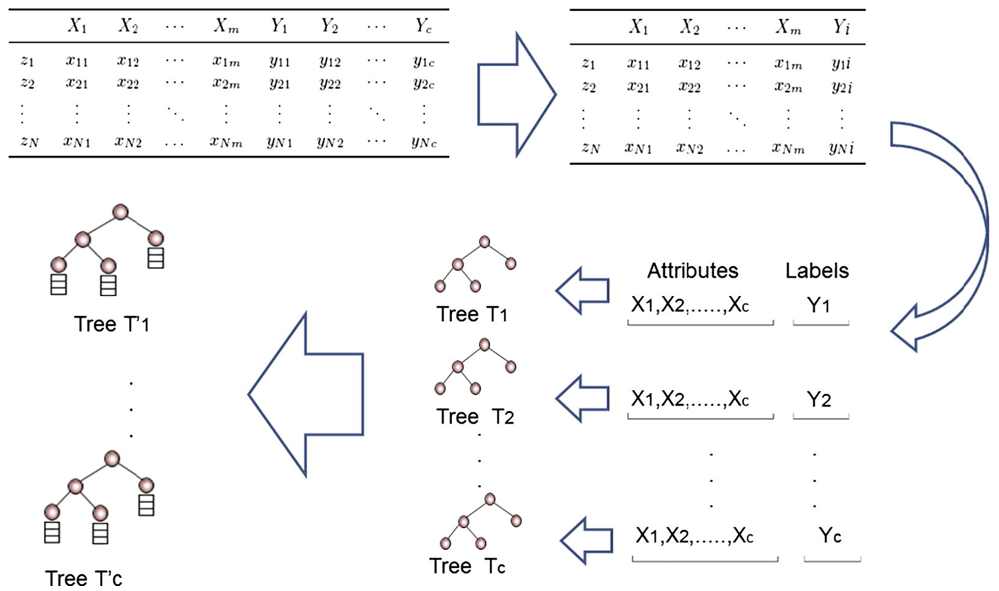

In [6]:
class BinaryRelevanceClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, base_model=RandomForestClassifier()):
        # By default RandomForest Classifier is set as the base model.
        self.base_model = base_model 
    
    # To map the input and output of the yeast dataset into the classifier model.
    def fit(self, X, y):
        self.models = []
        
        #For every target class in y, train the classifer independently.
        for class_ in y:  
            # So as to keep the model mutualy exclusive from other models.
            mdl = clone(self.base_model)
            
            # Validating the input X and particular target class of y to be of consistent length and 2D and 1D shape respectively.
            x_check,y_check = check_X_y(X, y[class_])
            
            # Fit the classifier for the particular target class.
            mdl.fit(x_check,y_check) 
            
            # Keeps the track of model trained on each target class.
            self.models.append(mdl) 
            
#=========================================================================================================================================

    # To predict the output class for X_test yeast dataset (726 entries).
    def predict(self,X_test):

        # Validation check on all the trained models whether they have been fitted or not before predicting the output.
        check_is_fitted(self, ['models']) 

        # Validating the input X_test to be of consistent length and 2D shape with finite values.
        X_test = check_array(X_test)
        
        # A dictionary to store all the predictions by coressponding models.
        pred_dict = {}
        i = 1
        
        # We are trying to predict the target class for all the X_test dataset by corressponding model trained using fit().
        for model in self.models:
            y_pred = model.predict(X_test)
            
            # Add current prediction by current model to the dictionary.
            pred_dict[i] = y_pred
            i += 1

        # Converting the dictionary to dataframe and then converting to numpy array
        pred_dict = pd.DataFrame(pred_dict)
        
        return pred_dict.to_numpy()    
    
#=========================================================================================================================================

    def predict_proba(self,X_test):
        
        # Validation check on all the models trained.
        check_is_fitted(self, ['models'])

        # Validating the input X_test to be of consistent length and 2D shape with finite values.
        X_test = check_array(X_test)
        
        # A dictionary to store all the predictions by coressponding models.
        pred_proba_dict = {}
        i = 1
        
        # We are trying to predict the target class for all the X_test dataset by corressponding model trained using fit().
        for model in self.models:
            y_pred_proba = model.predict_proba(X_test)
            
            # Considering only the probability of label 1 and storing it to the dictionary.
            pred_proba_dict[i] = [one_prob[1] for one_prob in y_pred_proba]
            i += 1

        #Converting the dictionary to dataframe and then converting to numpy array
        pred_proba_dict = pd.DataFrame(pred_proba_dict)
        return pred_proba_dict.to_numpy()

In [7]:
# To calculate the accuracy score while comparing the actual and predicted outputs.

def get_accuracy(y_test,y_pred):
    
    # If the shape of y_test and y_pred is not same, it will simply throw an error and break.
    assert(y_test.shape == y_pred.shape)
    
    j = 0
    # matches list is initially set with all 1s.
    matches = [1] * y_test.shape[0]

    # Say the threshold is 10 which means if 10/14 matches in y_pred and y_test, then the output would be 1 else 0.
    num_matches = 10

    for j in range(len(y_test)):
        # Counting the correctly predicted labels by y_pred for every target class of y_test .
        
        count = np.count_nonzero(y_test.iloc[j].values == y_pred[j])
      
        if count < num_matches:
            matches[j] = 0
 
    accuracy_score = sum(matches) / len(y_test)
    
    return accuracy_score

In [8]:
# Applying the Binary relevance algorithm to the dataset.
binary_classifier = BinaryRelevanceClassifier(base_model=RandomForestClassifier())

# Model training.
binary_classifier.fit(X_train,y_train)

# Predicting the output of X_test dataset.
y_pred = binary_classifier.predict(X_test)

print('Predicted output: ')
print(y_pred)

Predicted output: 
[[1 0 0 ... 1 1 0]
 [0 0 1 ... 1 1 0]
 [0 0 0 ... 1 1 0]
 ...
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 0 0 0]]


In [9]:
# Predicting the probabilities of label 0 and label 1 on X_test dataset.
print('Predicted probabilities: ')
binary_classifier.predict_proba(X_test)

Predicted probabilities: 


array([[0.7, 0.2, 0.3, ..., 0.6, 0.8, 0. ],
       [0.2, 0.1, 0.6, ..., 0.9, 0.6, 0. ],
       [0.2, 0.2, 0.3, ..., 0.7, 0.7, 0. ],
       ...,
       [0.4, 0.4, 0. , ..., 0.7, 0.6, 0. ],
       [0.3, 0.1, 0.4, ..., 0.7, 0.8, 0. ],
       [0.3, 0.1, 0.1, ..., 0.5, 0.4, 0. ]])

In [10]:
# Calculating the accuracy score (sklearn.metrics).
print('Accuracy from sklearn.metric',round(accuracy_score(y_test,y_pred)*100,2),'%')

# OUTPUT:
# Low accuracy because accuracy_score tries to match every individual target and if even a single target is predicted 0, it assumes the output to be 0.

Accuracy from sklearn.metric 10.74 %


In [11]:
# Here we are trying to match each label of y_test with coressponding label in y_pred.

acc_score = round(get_accuracy(y_test,y_pred)*100,2)
print('Accuracy score from self defined function:', acc_score , '%')

# OUTPUT:
# A threshold is set. If 10 or more labels out of 14 are correctly predcited, then it assumes it to be 1 else 0.

Accuracy score from self defined function: 80.03 %


In [12]:
# Macro Averaging while calculating the F1 score.
F1_unsampled = round(f1_score(y_test, y_pred, average='macro')*100,2)
print('F1 score for the Binary Relevence Algorithm :',F1_unsampled)

F1 score for the Binary Relevence Algorithm : 34.66


In [13]:
# GRID SEARCH

# Add a dictionary of classifiers and their related parameters in this param grid.
params_grid = [
                {'base_model':[LogisticRegression()],'base_model__max_iter':[1000,20000,40000]},
                {'base_model':[DecisionTreeClassifier()],'base_model__criterion': ["gini", "entropy"],'base_model__max_depth': [None, 10, 25, 50], 'base_model__min_samples_split':[2,5,10]},
                {'base_model': [RandomForestClassifier()],'base_model__min_samples_split':[2,8,10], 'base_model__n_estimators':[100,500,1000]}  
              ]

# Perform the search
my_tuned_model = GridSearchCV(BinaryRelevanceClassifier(), params_grid, verbose = 2, n_jobs=-1, scoring=make_scorer(get_accuracy))
my_tuned_model.fit(X_train, y_train)

# Print details
print("Best parameters set:")
print(my_tuned_model.best_params_)
print(my_tuned_model.best_score_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed: 10.6min finished


Best parameters set:
{'base_model': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), 'base_model__min_samples_split': 8, 'base_model__n_estimators': 1000}
0.8344175044352454


### Best Model Evaluation

In [14]:
# Evaluating with best model.
y_pred = my_tuned_model.predict(X_test)
print('Predicted output: ')
print(y_pred)

print('\nPredicted Probabilities:')
print(my_tuned_model.predict_proba(X_test))

acc_score = round(get_accuracy(y_test,y_pred)*100,2)
print('\nAccuracy score for best model:', acc_score , '%')

F1_unsampled = round(f1_score(y_test, y_pred, average='macro')*100,2)
print('\nF1 score for the best model: ',F1_unsampled,'%')

Predicted output: 
[[0 0 0 ... 1 1 0]
 [0 0 1 ... 1 1 0]
 [0 0 0 ... 1 1 0]
 ...
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 1 1 0]
 [0 0 1 ... 1 1 0]]

Predicted Probabilities:
[[0.38745048 0.38039551 0.31260683 ... 0.84733834 0.81959687 0.01099237]
 [0.14989805 0.30108379 0.61497979 ... 0.79841443 0.80141228 0.02106279]
 [0.45143718 0.43401202 0.30158242 ... 0.71005939 0.67666185 0.02432453]
 ...
 [0.3571054  0.45717904 0.15923237 ... 0.70376818 0.71668287 0.00284722]
 [0.23140751 0.44696952 0.39241084 ... 0.69380578 0.71950798 0.01645592]
 [0.27747215 0.38470309 0.53018206 ... 0.59225508 0.5781207  0.03291832]]

Accuracy score for best model: 82.78 %

F1 score for the best model:  35.16 %


## Task 2: Implement the Binary Relevance Algorithm with Under-Sampling

<b> UNDER SAMPLING </b> [2]
<br> For extreme imbalanced dataset, undersampling is performed on the majority class. </br> The imbalance in the classes can impact the performance of the classifier due to its bias nature towards majority class.

In [15]:
class BinaryRelevanceClassifier_UnderSampled(BaseEstimator, ClassifierMixin):
    
    def __init__(self, base_model=RandomForestClassifier()):
        # Default RandomForest Classifier is set as the base model.
        self.base_model = base_model 
    
    # To map the input and output of the yeast dataset into the classifier model.
    def fit(self, X, y):
        
        self.models = []
        
        #For every label in y, fit the model independently
        for class_ in y: 
            X_copy = X.copy()
            
            # Clone the base model to avoid overwriting
            mdl = clone(self.base_model) 
            
            # Joining X_copy and current target class 
            xy_concat = pd.concat([X_copy, pd.DataFrame(y[class_])], axis = 1)
            
            # Counting the labels 0 and 1 in the current target class.
            label0 = sum(y[class_]==0)
            label1 = sum(y[class_]==1)
            
            # Check the proportion of labels(0 & 1) in the X_train and current class column
            proportion = label1/label0
            
            # If the proportion is too low, Label0 is the majority class which implies we need to undersample the label0 class according to label1 class.
            if proportion < 0.35: 
                df_label1 = xy_concat[xy_concat[class_]==1]
                df_label0 = xy_concat[xy_concat[class_]==0].sample(label1) 
                xy_concat = pd.concat([df_label0, df_label1], axis=0)
                
            # If the proportion is too high, Label1 is the majority class which implies we need to undersample the label1 class according to label0 class.
            elif proportion >= 3:
                df_label1 = xy_concat[xy_concat[class_]==1].sample(label0)
                df_label0 = xy_concat[xy_concat[class_]==0] 
                xy_concat = pd.concat([df_label0, df_label1], axis=0)
             
            #Segregating the concatenated data into X and y again for further processing.
            X_copy = xy_concat.iloc[:,:-1]
            y_column = xy_concat.iloc[:,-1]
            
            # Validating the input X and particular target class of y to be of consistent length and 2D and 1D shape respectively.
            x_check,y_check = check_X_y(X_copy, y_column)
            
            # Fit the classifier for the particular target class.
            mdl.fit(x_check,y_check) 
            
            # Keeps the track of model trained on each target class.
            self.models.append(mdl) 
#=========================================================================================================================================

    # To predict the output class for X_test yeast dataset (726 entries).
    def predict(self,X_test):

        # Validation check on all the trained models whether they have been fitted or not before predicting the output.
        check_is_fitted(self, ['models']) 

        # Validating the input X_test to be of consistent length and 2D shape with finite values.
        X_test = check_array(X_test)
    
        # A dictionary to store all the predictions by coressponding models.
        pred_dict = {}
        i = 1
        
        # We are trying to predict the target class for all the X_test dataset by corressponding model trained using fit().
        for model in self.models:
            y_pred = model.predict(X_test)
            
            # Add current prediction by current model to the dictionary.
            pred_dict[i] = y_pred
            i += 1

        # Converting the dictionary to dataframe and then converting to numpy array
        pred_dict = pd.DataFrame(pred_dict)
        
        return pred_dict.to_numpy()
    
#=========================================================================================================================================

    def predict_proba(self,X_test):
        
        # Validation check on all the models trained.
        check_is_fitted(self, ['models'])

        # Validating the input X_test to be of consistent length and 2D shape with finite values.
        X_test = check_array(X_test)
        
        # A dictionary to store all the predictions by coressponding models.
        pred_proba_dict = {}
        i = 1
        
        # We are trying to predict the target class for all the X_test dataset by corressponding model trained using fit().
        for model in self.models:
            y_pred_proba = model.predict_proba(X_test)
            
            # Considering only the probability of label 1 and storing it to the dictionary.
            pred_proba_dict[i] = [prob_1[1] for prob_1 in y_pred_proba]
            i += 1
        
        #Converting the dictionary to dataframe and then converting to numpy array
        pred_proba_dict = pd.DataFrame(pred_proba_dict)
        return pred_proba_dict.to_numpy()

In [16]:
# Applying the Binary relevance algorithm with undersampling to the input dataset.
binary_classifier_undersampled = BinaryRelevanceClassifier_UnderSampled(base_model=RandomForestClassifier())

# Model training.
binary_classifier_undersampled.fit(X_train,y_train)

# Predicting the output of X_test dataset.
y_pred_sampled = binary_classifier_undersampled.predict(X_test)
print('Predicted output: ')
print(y_pred_sampled)

y_pred_proba_sampled = binary_classifier_undersampled.predict_proba(X_test)
print('Predicted probabilities: ')
print(y_pred_proba_sampled)

Predicted output: 
[[0 0 0 ... 1 0 1]
 [0 0 1 ... 1 1 1]
 [0 0 0 ... 1 0 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 1 ... 0 1 0]]
Predicted probabilities: 
[[0.2 0.3 0.2 ... 0.7 0.5 0.8]
 [0.2 0.3 0.6 ... 0.8 0.8 0.6]
 [0.4 0.2 0.3 ... 0.7 0.5 0.6]
 ...
 [0.3 0.3 0.3 ... 0.5 0.4 0.3]
 [0.3 0.4 0.4 ... 0.2 0.3 0.8]
 [0.2 0.5 0.8 ... 0.4 0.6 0.5]]


In [17]:
# Calculating the accuracy score (sklearn.metrics).
print('Accuracy from sklearn.metric',round(accuracy_score(y_test,y_pred_sampled)*100,2),'%')

# OUTPUT:
# Low accuracy because accuracy_score tries to match every individual target and if even a single target is predicted 0, it assumes the output to be 0.


# Here we are trying to match each label of y_test with coressponding label in y_pred.
print('Accuracy score from self defined function:', round(get_accuracy(y_test,y_pred_sampled)*100,2) , '%')

# OUTPUT:
# A threshold is set. If 10 or more labels out of 14 are correctly predcited, then it assumes it to be 1 else 0.


# Macro Averaging while calculating the F1 score.
print('F1 Score for under sampled dataset: ',f1_score(y_test, y_pred_sampled, average='macro'))

Accuracy from sklearn.metric 1.24 %
Accuracy score from self defined function: 41.74 %
F1 Score for under sampled dataset:  0.3903939956839568


In [18]:
# GRID SEARCH

# Add a dictionary of classifiers and their related parameters in this param grid.
params_grid = [
                {'base_model':[LogisticRegression()],'base_model__max_iter':[1000,20000,40000]},
                {'base_model':[DecisionTreeClassifier()],'base_model__criterion': ["gini", "entropy"],'base_model__max_depth': [None, 10, 25, 50], 'base_model__min_samples_split':[2,5,10]},
                {'base_model': [RandomForestClassifier()],'base_model__min_samples_split':[2,8,10], 'base_model__n_estimators':[100,500,1000]}  
              ]

# Perform the Grid search
my_tuned_model = GridSearchCV(BinaryRelevanceClassifier(), params_grid, verbose = 2, n_jobs=-1, scoring=make_scorer(get_accuracy))
my_tuned_model.fit(X_train, y_train)

# Print details
print("Best parameters set:")
print(my_tuned_model.best_params_)
print(my_tuned_model.best_score_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  7.5min finished


Best parameters set:
{'base_model': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), 'base_model__min_samples_split': 2, 'base_model__n_estimators': 500}
0.8332347723240686


### Best Model Evaluation without Under Sampling

In [19]:
# Evaluating with best model after under sampling.
y_pred = my_tuned_model.predict(X_test)
print('Predicted output: ')
print(y_pred)

print('\nPredicted Probabilities:')
print(my_tuned_model.predict_proba(X_test))

acc_score = round(get_accuracy(y_test,y_pred)*100,2)
print('\nAccuracy score for best model:', acc_score , '%')

F1_unsampled = round(f1_score(y_test, y_pred, average='macro')*100,2)
print('\nF1 score for the best model: ',F1_unsampled,'%')

Predicted output: 
[[0 0 0 ... 1 1 0]
 [0 0 1 ... 1 1 0]
 [0 0 0 ... 1 1 0]
 ...
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 1 1 0]
 [0 0 1 ... 1 1 0]]

Predicted Probabilities:
[[0.358 0.412 0.324 ... 0.864 0.832 0.018]
 [0.152 0.318 0.634 ... 0.828 0.77  0.022]
 [0.45  0.438 0.278 ... 0.672 0.69  0.028]
 ...
 [0.34  0.492 0.174 ... 0.732 0.702 0.002]
 [0.28  0.456 0.368 ... 0.734 0.74  0.01 ]
 [0.256 0.354 0.512 ... 0.59  0.584 0.034]]

Accuracy score for best model: 83.47 %

F1 score for the best model:  35.19 %


## Task 3: Compare the Performance of Different Binary Relevance Approaches

In [20]:
# Dictionaries to store the accuracy score and F1 score for every classifier.(with and without Undersampling)
dict_1 = {}
dict_2 = {}

flag = 0

classifiers = [LogisticRegression(),DecisionTreeClassifier(),RandomForestClassifier()]

for classifier in classifiers:

    mod1 = BinaryRelevanceClassifier(base_model=classifier)
    mod1.fit(X_train,y_train)
    y_pred = mod1.predict(X_test)
    
    # Accuracy Score 
    acc_score = get_accuracy(y_test,y_pred)
    
    # F1 Score calculation
    F1_score = f1_score(y_test, y_pred, average='macro')
    
    if flag == 0:
        dict_1['LogReg'] = {'Accuracy Score': acc_score, 'F1 Score': F1_score}
    elif flag == 1:
        dict_1['DecTree'] = {'Accuracy Score': acc_score, 'F1 Score': F1_score}
    elif flag == 2:
        dict_1['RanForest'] = {'Accuracy Score': acc_score, 'F1 Score': F1_score}    
    
#===========================================================================================================

    mod2 = BinaryRelevanceClassifier_UnderSampled(base_model=classifier)
    mod2.fit(X_train,y_train)
    y_pred_un = mod2.predict(X_test)
    
    # Accuracy Score 
    acc_score_sampled = get_accuracy(y_test,y_pred_un)
    
    # F1 Score calculation
    F1_score_sampled = f1_score(y_test, y_pred_un, average='macro')
    
    if flag == 0:
        dict_2['LogReg'] = {'Accuracy Score': acc_score_sampled, 'F1 Score': F1_score_sampled}
    elif flag == 1:
        dict_2['DecTree'] = {'Accuracy Score': acc_score_sampled, 'F1 Score': F1_score_sampled}
    elif flag == 2:
        dict_2['RanForest'] = {'Accuracy Score': acc_score_sampled, 'F1 Score': F1_score_sampled}
    
    flag += 1

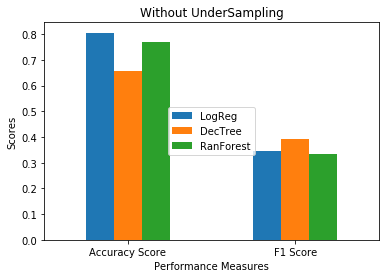

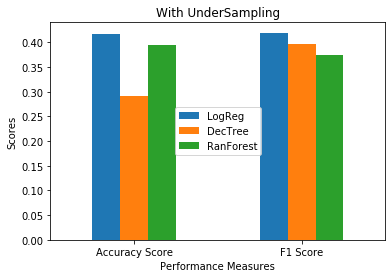

In [21]:
dframe_wout_Sample = pd.DataFrame(dict_1)
dframe_wout_Sample.plot(kind = 'bar', rot = 0)
plt.title('Without UnderSampling')
plt.xlabel('Performance Measures')
plt.ylabel('Scores')
plt.legend(loc = 10)


dframe_with_Sample = pd.DataFrame(dict_2)
dframe_with_Sample.plot(kind = 'bar', rot = 0)
plt.title('With UnderSampling')
plt.xlabel('Performance Measures')
plt.ylabel('Scores')
plt.legend(loc = 10)
plt.show()

## Task 4: Implement the Classifier Chains Algorithm

### CLASSIFIER CHAIN [3]

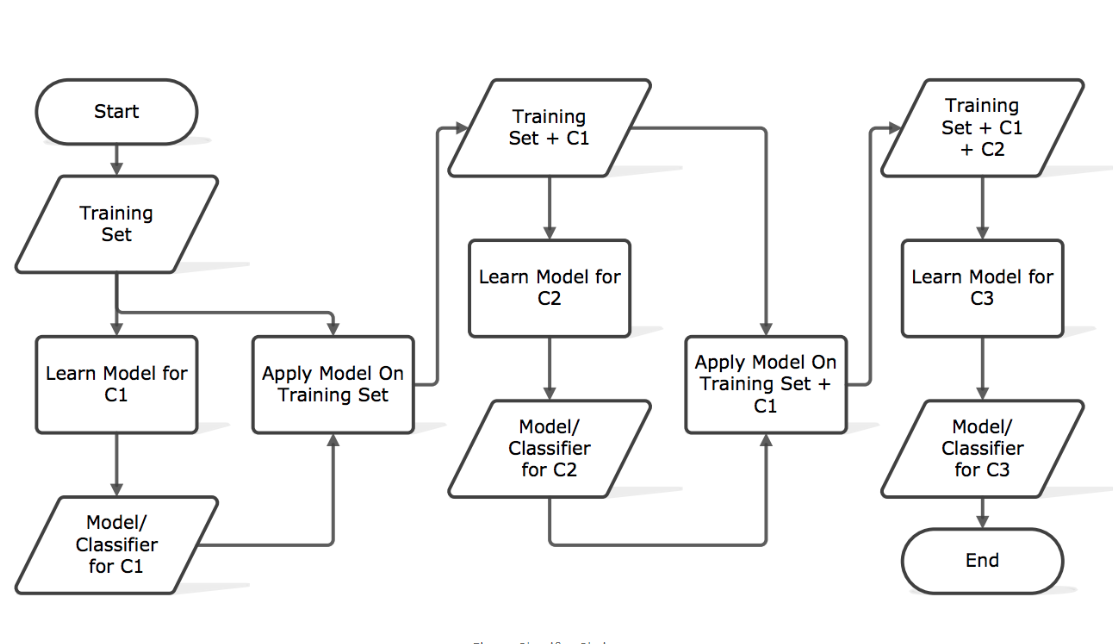

In [22]:
class ClassifierChains(BaseEstimator, ClassifierMixin):
    
    def __init__(self, base_model=LogisticRegression(), order = None, undersample=False):
        self.base_model = base_model
        self.order = order
        self.undersample = undersample
        
    def fit(self, X, y):
        # A deep copy of X_train and y_train is generated.
        copy_X = X.copy()
        copy_y = y.copy()

        # The order is None by default and the original order be [0,1,2,3,,,,13]
        self.order_shuffle = None
        self.original_order = list(range(len(y.columns)))
        
        # If the order comes to be None, shuffling order will be same as the original order. 
        if self.order is None:
            self.order_shuffle = self.original_order
            
        # In case of random order, the order list [0,1,2,.....13] is shuffled randomly.
        elif self.order == 'random':
            self.order_shuffle = list(range(len(copy_y.columns)))
            random.shuffle(list(range(len(copy_y.columns))))
            #print(self.order_shuffle)
        
        # Since the order is shuffled now, So the y_train data set should also be of the same order.
        copy_y = copy_y.iloc[:,self.order_shuffle]        
        
        self.models = []
        #For every label in y, fit the model with previous input dataset and label collectively.
        for class_ in copy_y:
            
            # Using default index(0,1.....X_copy.shape[0])
            copy_X.reset_index(drop=True, inplace=True)
            copy_y.reset_index(drop=True, inplace=True)
            
            # Creating this copy of copy in case undersampling = True. We will do undersampling on X_copy
            X_copy = copy_X.copy()
            
            if self.undersample:                      
                # Joining X_copy and current target class 
                xy_concat = pd.concat([X_copy, pd.DataFrame(y[class_])], axis = 1)

                #Dividing the labels
                label0 = sum(y[class_]==0)
                label1 = sum(y[class_]==1)

                #print(label1, label0)

                # Check the proportion of labels(0 & 1) in the X_train and current class column
                proportion = label1/label0
                
                #  If the proportion is too low, Label0 is the majority class which implies we need to undersample the label0 class according to label1 class.
                if proportion < 0.35: 
                    df_label1 = xy_concat[xy_concat[class_]==1]
                    df_label0 = xy_concat[xy_concat[class_]==0].sample(label1) 
                    xy_concat = pd.concat([df_label0, df_label1], axis=0)

                #  If the proportion is too high, Label1 is the majority class which implies we need to undersample the label1 class according to label0 class.
                elif proportion >= 3:
                    df_label1 = xy_concat[xy_concat[class_]==1].sample(label0)
                    df_label0 = xy_concat[xy_concat[class_]==0] 
                    xy_concat = pd.concat([df_label0, df_label1], axis=0)

                # Segregating the concatenated data into X and y again for further processing.
                X_copy = xy_concat.iloc[:,:-1]
                y_column = xy_concat.iloc[:,-1]

            else:
                y_column = copy_y[class_]
                
            classifier = clone(self.base_model)
            
            # Validating the input X and particular target class of y to be of consistent length and 2D and 1D shape respectively.
            x_check,y_check = check_X_y(X_copy, y_column)
            
            # Fit the classifier for the particular target class.
            classifier.fit(x_check,y_check)
            
            # Keeps the track of model trained on each target class.
            self.models.append(classifier)
            
            # Crux of classifier chain
            # The X_train dataset and the target class of y_train dataset are combined together to become the input for the next model. 
            copy_X = pd.concat([copy_X, copy_y[class_]], axis=1)        
#===========================================================================================================            
    
    def predict(self,X):
        
        # To prevent the original training dataset.
        X_cpy = X.copy()
        
        # Default indexing from 0...len(X_test)
        X_cpy.reset_index(drop=True, inplace=True)
               
        # Validation check on all the trained models whether they have been fitted or not before predicting the output.
        check_is_fitted(self, ['models']) 

        # Validating the input X_test to be of consistent length and 2D shape with finite values.
        X_cpy = check_array(X_cpy)
        
        # A dictionary to store all the predictions by coressponding models.
        pred_dict = {}
        i = 0
        
        # We are trying to predict the target class for all the X_test dataset by corressponding model trained using fit().
        for model in self.models:
            y_pred = model.predict(X_cpy)
            
            # Add current prediction by current model to the dictionary.
            pred_dict[self.order_shuffle[i]] = y_pred
            
            # Attaching the output predicted by individual model to the X_test dataset.
            # So that next model will get the input dataset as (X_test + Previous model predictions).
            y_pred = y_pred.reshape(726,1)
            X_cpy = np.concatenate((X_cpy, y_pred), axis=1)
            
            i += 1
            
        # Converting the dictionary to dataframe and then converting to numpy array
        pred_dict = pd.DataFrame(pred_dict)
        
        pred_dict = pred_dict.loc[:,self.original_order]
        return pred_dict.to_numpy()
    
#===========================================================================================================            

    def predict_proba(self,X):
        # To prevent the original training dataset.
        X_cpy = X.copy()
        
        # Default indexing from 0...len(X_test)
        X_cpy.reset_index(drop=True, inplace=True)
        
        # Validation check on all the trained models whether they have been fitted or not before predicting the output.
        check_is_fitted(self, ['models'])
        
        # Validating the input X_test to be of consistent length and 2D shape with finite values.
        X_cpy = check_array(X_cpy)
        
        # A dictionary to store all the predictions by coressponding models.
        pred_dict = {}
        i = 0
        
        # We are trying to predict the target class for all the X_test dataset by corressponding model trained using fit().
        for model in self.models:
            # Predicting the output for X_test
            y_pred = model.predict(X_cpy)
            
            # Predicting the Probabilities of the output for X_test.
            y_pred_proba = model.predict_proba(X_cpy)
            
            # Add current prediction by current model to the dictionary.
            pred_dict[self.order_shuffle[i]] = [one_prob[1] for one_prob in y_pred_proba]
            
            # Attaching the output predicted by individual model to the X_test dataset.
            # So that next model will get the input dataset as (X_test + Previous model predictions).
            y_pred = y_pred.reshape(726,1)
            X_cpy = np.concatenate((X_cpy, y_pred), axis=1)
            
            i+=1
        
        # Converting the dictionary to dataframe and then converting to numpy array
        pred_dict = pd.DataFrame(pred_dict)
        
        pred_dict = pred_dict.loc[:,self.original_order]
        return pred_dict.to_numpy()

In [23]:
# Applying the Classifier chain to the input dataset.
classifier_chain = ClassifierChains(base_model=RandomForestClassifier(), undersample = False, order ='random')

# Model training.
classifier_chain.fit(X_train,y_train)

# Predicting the output of X_test dataset.
y_pred_chain = classifier_chain.predict(X_test)
print('\nPredicted output:')
print(y_pred_chain)

# Predicting the probabilities of label 0 and label 1 on X_test dataset.
print('\nPredicted probabilities: ')
print(classifier_chain.predict_proba(X_test))


Predicted output:
[[0 0 0 ... 1 1 0]
 [0 0 1 ... 1 1 0]
 [0 0 0 ... 1 1 0]
 ...
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 1 1 0]
 [0 0 1 ... 0 0 0]]

Predicted probabilities: 
[[0.5 0.5 0.2 ... 0.9 0.9 0. ]
 [0.1 0.1 0.6 ... 0.9 1.  0. ]
 [0.3 0.3 0.2 ... 0.8 1.  0. ]
 ...
 [0.3 0.1 0.3 ... 0.9 1.  0. ]
 [0.1 0.2 0.4 ... 0.7 0.8 0.1]
 [0.2 0.3 0.6 ... 0.5 0.  0.1]]


In [24]:
acc_score_chain = round(get_accuracy(y_test,y_pred_chain)*100,2)
print('\nAccuracy score for classifier chain:', acc_score_chain , '%')

F1_chain = round(f1_score(y_test, y_pred_chain, average='macro')*100,2)
print('\nF1 score for the classifier chain: ',F1_chain,'%')


Accuracy score for classifier chain: 80.44 %

F1 score for the classifier chain:  34.68 %


## Task 5: Evaluate the Performance of the Classifier Chains Algorithm

In [25]:
# The best model after performing the Grid Search for Binary Relevence Algorithm comes out to be: RandomForest()
dict_ = {}

print('\nBinary Relevence without Under Sampling')
binary_classifier = BinaryRelevanceClassifier(base_model=RandomForestClassifier())
binary_classifier.fit(X_train,y_train)

y_pred = binary_classifier.predict(X_test)

#print('\nPredicted output: ')
#print(y_pred)

# Predicting the probabilities of label 0 and label 1 on X_test dataset.
#print('Predicted Probabilities:')
#print(binary_classifier.predict_proba(X_test))

acc_score_unsampled = round(get_accuracy(y_test,y_pred)*100,2)
print('\nAccuracy score:', acc_score_unsampled , '%')

# Macro Averaging while calculating the F1 score.
F1_unsampled = round(f1_score(y_test, y_pred, average='macro')*100,2)
print('\nF1 Score:',F1_unsampled)


dict_['BinRel_wo_Sample'] = {'Accuracy_Score':acc_score_unsampled , 'F1_Score':F1_unsampled}
#=======================================================================================================================


Binary Relevence without Under Sampling

Accuracy score: 79.61 %

F1 Score: 33.69


In [26]:
print('\nBinary Relevence with Under Sampling')
binary_sampled_classifier = BinaryRelevanceClassifier_UnderSampled(base_model=RandomForestClassifier())
binary_sampled_classifier.fit(X_train,y_train)

y_pred_sampled = binary_sampled_classifier.predict(X_test)
#print('\nPredicted output: ')
#print(y_pred_sampled)

# Predicting the probabilities of label 0 and label 1 on X_test dataset.
#print('Predicted Probabilities:')
#print(binary_classifier.predict_proba(X_test))

acc_score_sampled = round(get_accuracy(y_test,y_pred_sampled)*100,2)
print('\nAccuracy score:', acc_score_sampled , '%')

# Macro Averaging while calculating the F1 score.
F1_sampled = round(f1_score(y_test, y_pred_sampled, average='macro')*100,2)
print('\nF1 Score:',F1_sampled)

dict_['BinRel_with_Sample'] = {'Accuracy_Score':acc_score_sampled , 'F1_Score':F1_sampled}
#=======================================================================================================================


Binary Relevence with Under Sampling

Accuracy score: 44.08 %

F1 Score: 38.9


In [27]:
print('\nClassifier Chain: ')
classifier_chain = ClassifierChains(base_model=RandomForestClassifier(), order = 'random', undersample= False)
classifier_chain.fit(X_train,y_train)

y_pred_chain = classifier_chain.predict(X_test)
#print('\nPredicted output: ')
#print(y_pred_chain)

# Predicting the probabilities of label 0 and label 1 on X_test dataset.
#print('Predicted Probabilities:')
#print(binary_classifier.predict_proba(X_test))

acc_score_chain = round(get_accuracy(y_test,y_pred_chain)*100,2)
print('\nAccuracy score:', acc_score_chain , '%')

# Macro Averaging while calculating the F1 score.
F1_chain = round(f1_score(y_test, y_pred_chain, average='macro')*100,2)
print('\nF1 Score:',F1_chain)

dict_['ClassifierChain'] = {'Accuracy_Score':acc_score_chain , 'F1_Score':F1_chain}
#=======================================================================================================================


Classifier Chain: 

Accuracy score: 79.75 %

F1 Score: 36.29


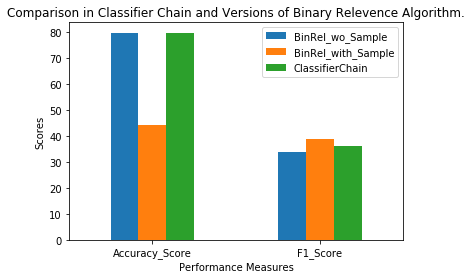

In [28]:
final_dframe = pd.DataFrame(dict_)
final_dframe.plot(kind = 'bar', rot = 0)
plt.title('Comparison in Classifier Chain and Versions of Binary Relevence Algorithm.')
plt.xlabel('Performance Measures')
plt.ylabel('Scores')
plt.legend(loc = 'upper right')
plt.show()

## Task 6: Reflect on the Performance of the Different Models Evaluated

## Taking both the multi-label classification techniques into consideration following conclusions can be made:

### 1. Binary Relevance

__Accuracy Score__
* Binary Relevance classifier without undersampling produces the best 80% accuracy (Using Logistic Regression)  which is greater than any other undersampling model.
* We just under-sample a majority class if the gap between majority and minority is too big. This result in loss of accuracy due reduction in training samples and hence the overall accuracy.

__F1 Score__
* Without undersampling, the binary relevance classifier has lower F1 scores resulting in high bias that leads to high accuracy and poor recall values. 
* But after undersampling the gap between majority and minority class gets reduced which results in better F1 score.


|  | Logistic Regression | Decision Tree | Random Forest |
| -------|---------------------|---------------|---------------|
| __Accuracy Score__ | 0.80 | 0.65 | 0.77 |
| __F1 Score(macro avg)__ | 0.34 | 0.39 | 0.33 |


### 2. Classifier Chain

* Classifier chain works better than Binary Relevance because it takes label dependency into consideration. But if the output of the very first model comes wrong then the subsequent model output will be impacted badly.

* This approach has more complexity than binary relevance because it requires the previous target labels as input for the next predictions.

* However it can be seen that there is no substantial difference between the model accuracy which is quite unexpected.

|  | Logistic Regression |
| -------|---------------|
| __Accuracy Score__ | 0.8044 |
| __F1 Score(macro avg)__ | 0.3468 |



#### References

[1] Medium. (2018). Deep dive into multi-label classification..! (With detailed Case Study). [online] Available at: https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff [Accessed 8 Mar. 2020]. 

[2] Brownlee, J. (2020). Undersampling Algorithms for Imbalanced Classification. [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/undersampling-algorithms-for-imbalanced-classification/ [Accessed 8 Mar. 2020].

[3] S. (2020). Solving Multi-Label Classification problems (Case studies included). [online] Analytics Vidhya. Available at: https://www.analyticsvidhya.com/blog/2017/08/introduction-to-multi-label-classification/ [Accessed 8 Mar. 2020]. 